## Image Classification using torchflare
***
* Dataset : https://www.kaggle.com/c/cifar-10
* Install nb_black: https://github.com/dnanhkhoa/nb_black

In [ ]:
import numpy as np
import pandas as pd
import albumentations as A

import torchflare.callbacks as cbs
import torchflare.metrics as metrics
from torchflare.datasets import SimpleDataloader , show_batch
from torchflare.experiments import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("trainLabels.csv")
classes = df.label.unique().tolist()
class_to_idx = {value: key for key, value in enumerate(classes)}
df.label = df.label.map(class_to_idx)
df.id = df.id.astype(str)

<IPython.core.display.Javascript object>

In [4]:
df.head()

,id,label
0,1,0
1,2,1
2,3,1
3,4,2
4,5,3


<IPython.core.display.Javascript object>

In [5]:
df.shape

(50000, 2)

<IPython.core.display.Javascript object>

In [6]:
from sklearn.model_selection import train_test_split

test_df = df.iloc[:10000, :]  # I took first 10000 entries as test data
data_df = df.iloc[10000:, :]
train_df, valid_df = train_test_split(data_df, test_size=0.3)

<IPython.core.display.Javascript object>

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Train Dataloader
train_dl = SimpleDataloader.image_data_from_df(
    path="./train",
    image_col="id",
    label_cols="label",
    augmentations=transform,
    df=train_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=32, shuffle=True)

# Validation Dataloader
valid_dl = SimpleDataloader.image_data_from_df(
    path="./train",
    image_col="id",
    label_cols="label",
    augmentations=transform,
    df=valid_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=16, num_workers=0)

# Test Transforms
test_transform = transforms.Compose([transforms.ToTensor()])

# Test dataloader
test_dl = SimpleDataloader.image_data_from_df(
    path="./train",
    image_col="id",
    label_cols=None,
    augmentations=test_transform,
    df=test_df,
    extension=".png",
    convert_mode="RGB",
).get_loader(batch_size=16, num_workers=0)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


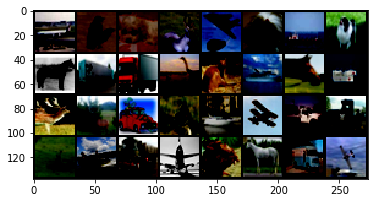

<IPython.core.display.Javascript object>

In [8]:
# Note show batch only works for image data(classification and segmentation.)
show_batch(train_dl, value_range=(0, 1))

In [9]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


<IPython.core.display.Javascript object>

In [10]:
net = Net()

<IPython.core.display.Javascript object>

In [11]:
metric_list = [metrics.Accuracy(num_classes=len(classes), multilabel=False)]
callbacks = [
    cbs.EarlyStopping(monitor="accuracy", patience=5),
    cbs.ModelCheckpoint(monitor="accuracy"),  # Always use lower case name of metric
]

<IPython.core.display.Javascript object>

In [12]:
exp = Experiment(
    num_epochs=5,
    save_dir="./models",
    model_name="cifar10.bin",
    fp16=False,
    using_batch_mixers=False,
    device="cuda",
    compute_train_metrics=True,
    seed=42,
)

<IPython.core.display.Javascript object>

In [13]:
exp.compile_experiment(
    model=net,
    optimizer="Adam",
    optimizer_params=dict(lr=3e-4),
    callbacks=callbacks,
    scheduler="ReduceLROnPlateau",
    scheduler_params=dict(mode="max", patience=5),
    criterion="cross_entropy",
    metrics=metric_list,
    main_metric="accuracy",
)

<IPython.core.display.Javascript object>

In [14]:
exp.perform_sanity_check(train_dl)

Sanity Check Completed. Model Forward Pass and Loss Computation Successful
Output Shape : torch.Size([32, 10])
Loss for a batch :2.2839059829711914


<IPython.core.display.Javascript object>

In [15]:
exp.run_experiment(train_dl=train_dl, valid_dl=valid_dl)

Epoch,train_loss,train_accuracy,val_loss,val_accuracy,Time
0,1.89916,0.30546,1.70383,0.37542,06:47
1,1.63439,0.40893,1.56637,0.42775,00:31
2,1.53299,0.44500,1.51328,0.45375,00:37
3,1.46115,0.47182,1.45357,0.47150,00:33
4,1.39868,0.49604,1.40831,0.49100,00:37


<IPython.core.display.Javascript object>

In [16]:
# Inference
ops = []
for op in exp.infer(path="./models/cifar10.bin", test_loader=test_dl):
    _, y_pred = torch.max(op, dim=1)
    ops.extend(y_pred)


<IPython.core.display.Javascript object>

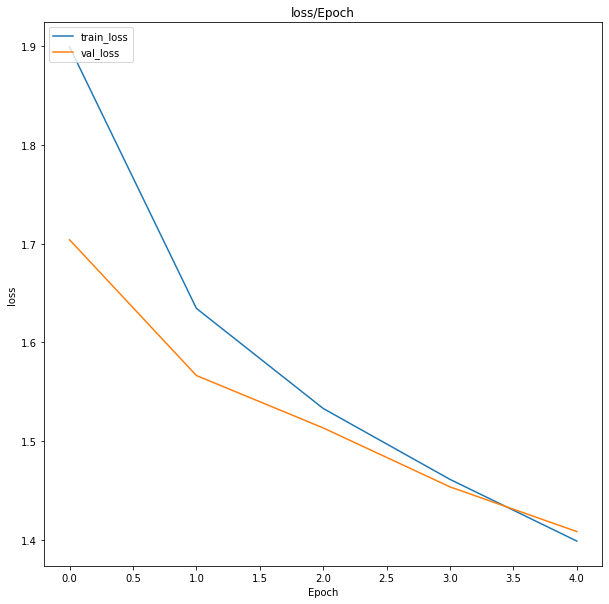

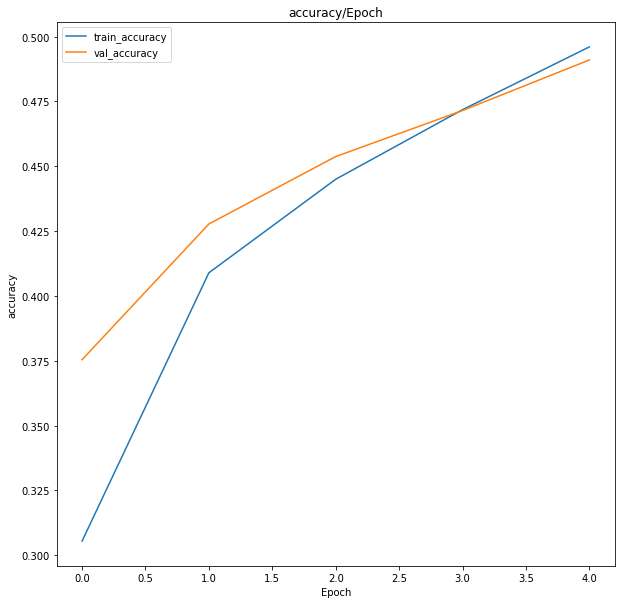

<IPython.core.display.Javascript object>

In [20]:
plot_metrics = ["loss", "accuracy"]
for metric in plot_metrics:
    exp.plot_history(key=metric, save_fig=False, plot_fig=True)